In [55]:
from __future__ import annotations

from dataclasses import dataclass
from moderngl import Buffer, Context, Program, VertexArray, Texture
from PIL import Image
from pyrr import Matrix44

import moderngl as mgl
import numpy as np

In [56]:
FRAME_SIZE  = 640, 480
COLOR_MODE  = "RGBA"
CLEAR_COLOR = 0.0, 0.0, 0.0

In [57]:
class HeadlessWindow:
    def __init__(
        self,
        size: tuple[int] = FRAME_SIZE,
        color_mode: str = COLOR_MODE,
        clear_color: tuple[float] = CLEAR_COLOR,
    ) -> None:
        self.size = self.width, self.height = size
        self.color_mode, self.channels = color_mode, len(color_mode)
        self.clear_color = (*clear_color, 1.0)

        self.ctx = mgl.create_context(standalone=True, backend="egl")
        self.fbo = self.ctx.simple_framebuffer(self.size, components=self.channels)
        self.fbo.use()

    def render(self) -> HeadlessWindow:
        self.ctx.clear(*self.clear_color)
        return self

    def show(self, flip: bool = True) -> None:
        img = Image.frombytes(self.color_mode, self.size, self.fbo.read(components=self.channels))
        img = img.transpose(Image.FLIP_TOP_BOTTOM) if flip else img
        display(img)

In [58]:
def pixel_shader(ctx: Context, fragment_shader: str) -> Program:
    vertex_shader = """
    #version 330

    in vec3 in_pos;
    in vec2 in_uv;

    out vec2 v_uv;

    void main() {
        gl_Position = vec4(in_pos, 1.0);
        v_uv = in_uv;
    }
    """
    return ctx.program(vertex_shader=vertex_shader, fragment_shader=fragment_shader)

In [59]:
def quad(ctx: Context, prog: Program) -> VertexArray:
    vbo = ctx.buffer(np.array([
         # x    y    z     u    v
         1.0,  1.0, 1.0,  1.0, 1.0,
         1.0, -1.0, 1.0,  1.0, 0.0,
        -1.0, -1.0, 1.0,  0.0, 0.0,
        -1.0,  1.0, 1.0,  0.0, 1.0,
    ], dtype=np.float32))
    ibo = ctx.buffer(np.array([0, 1, 3, 1, 2, 3], dtype=np.int32))
    return ctx.vertex_array(prog, [(vbo, "3f 2f", "in_pos", "in_uv")], ibo)

In [60]:
class PixelShader(HeadlessWindow):
    def __init__(self, fragment_shader, uniforms: dict = {}) -> None:
        super().__init__()
        self.prog = pixel_shader(self.ctx, fragment_shader)
        self.quad = quad(self.ctx, self.prog)
        for u_name, u_value in uniforms.items():
            self.prog[u_name].write(u_value)
        
    def render(self) -> PixelShader:
        super().render()
        self.quad.render(mode=mgl.TRIANGLES)
        return self

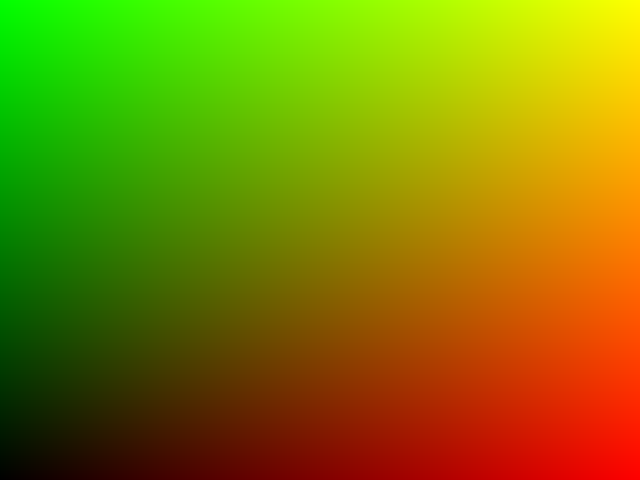

In [61]:
PixelShader("""
#version 330

in vec2 v_uv;

out vec4 f_color;

void main() {
    f_color = vec4(v_uv, 0.0, 1.0);
}
""").render().show()

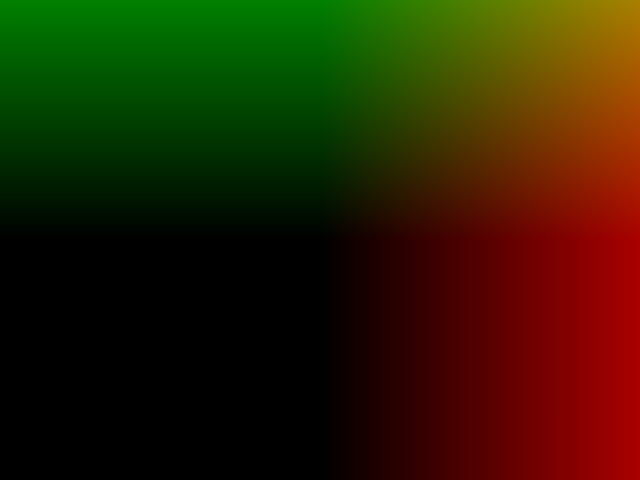

In [62]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    f_color = vec4(uv, 0.0, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

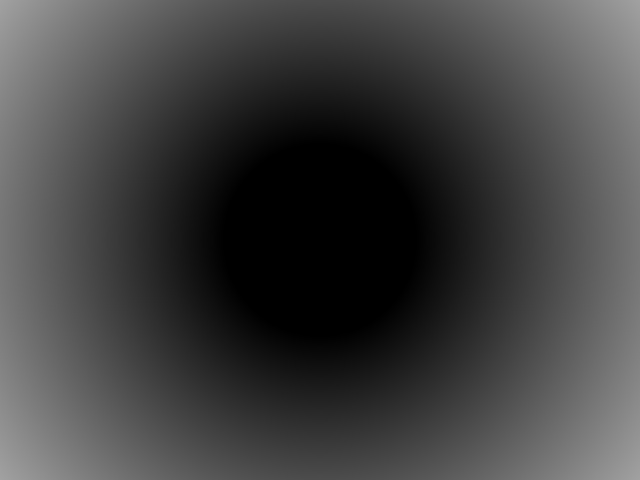

In [63]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = length(uv) - 0.2;
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

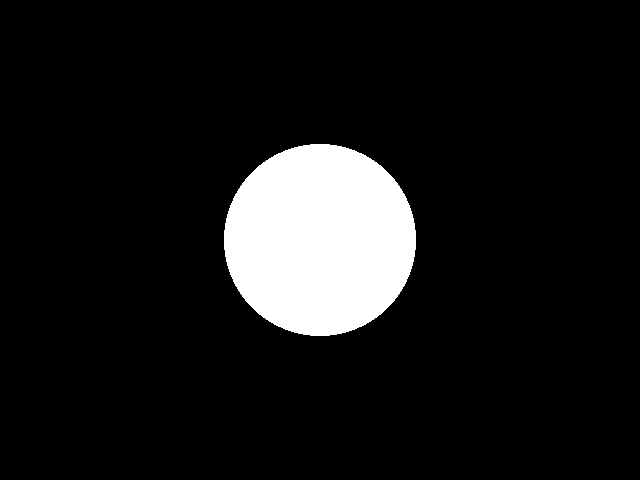

In [64]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = step(length(uv) - 0.2, 0);
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

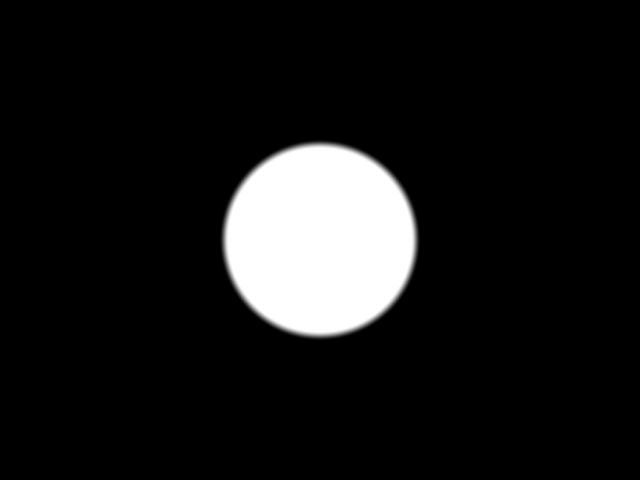

In [65]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = smoothstep(0.01, -0.01, length(uv) - 0.2);
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

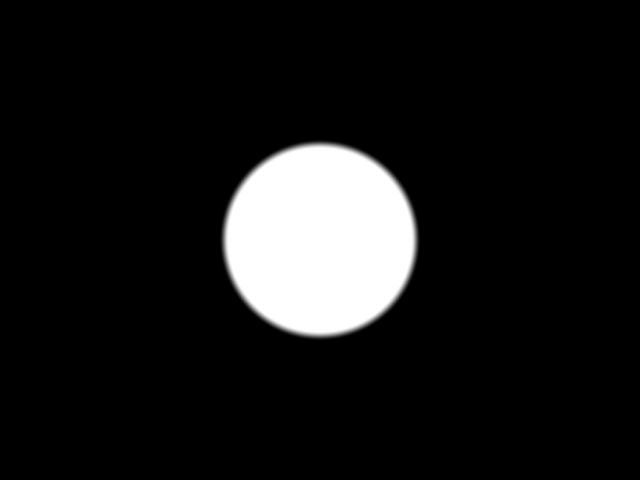

In [66]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_circle(vec2 p, float r) { return length(p) - r; }
float sdf_scene(vec2 p) { return sdf_circle(p, 0.2); }

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = smoothstep(0.01, -0.01, sdf_scene(uv));
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

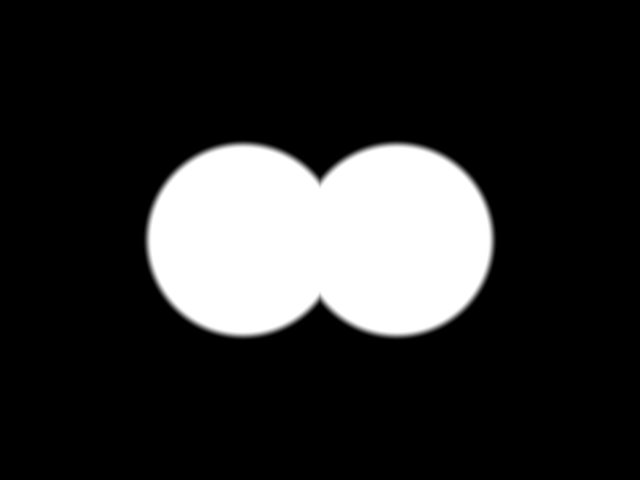

In [67]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_circle(vec2 p, float r) { return length(p) - r; }
float sdf_scene(vec2 p) {
    float sphere_a = sdf_circle(p - vec2(0.16, 0.0), 0.2);
    float sphere_b = sdf_circle(p + vec2(0.16, 0.0), 0.2);
    return min(sphere_a, sphere_b);
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = smoothstep(0.01, -0.01, sdf_scene(uv));
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

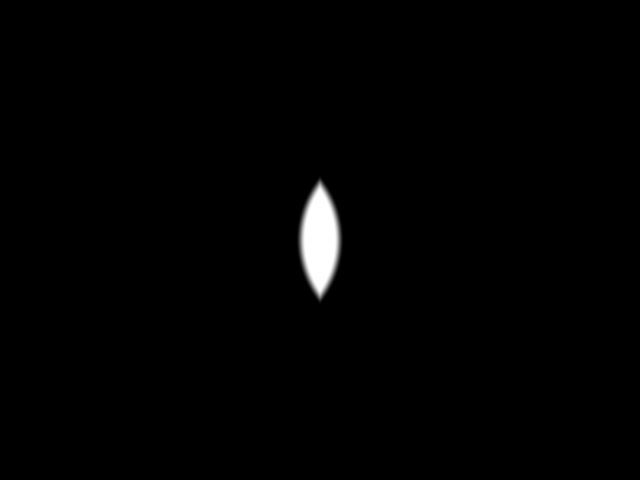

In [68]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_circle(vec2 p, float r) { return length(p) - r; }
float sdf_scene(vec2 p) {
    float sphere_a = sdf_circle(p - vec2(0.16, 0.0), 0.2);
    float sphere_b = sdf_circle(p + vec2(0.16, 0.0), 0.2);
    return max(sphere_a, sphere_b);
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = smoothstep(0.01, -0.01, sdf_scene(uv));
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

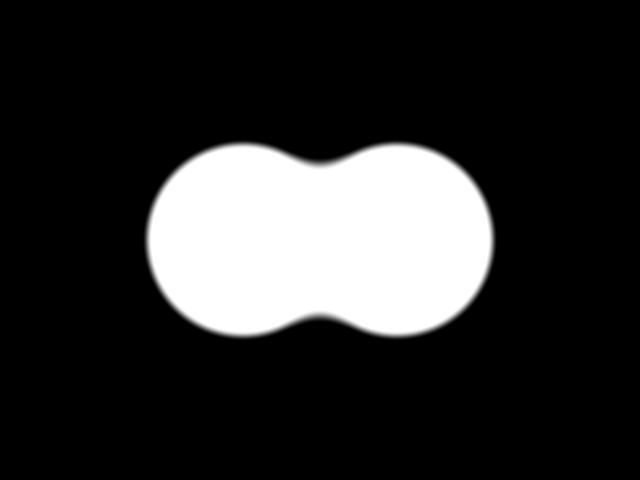

In [69]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sunion(float a, float b, float k) {
    float h = clamp(0.5 + 0.5 * (a - b) / k, 0.0, 1.0);
    return mix(a, b, h) - k * h * (1 - h);
}

float sdf_circle(vec2 p, float r) { return length(p) - r; }
float sdf_scene(vec2 p) {
    float sphere_a = sdf_circle(p - vec2(0.16, 0.0), 0.2);
    float sphere_b = sdf_circle(p + vec2(0.16, 0.0), 0.2);
    return sunion(sphere_a, sphere_b, 0.1);
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = smoothstep(0.01, -0.01, sdf_scene(uv));
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

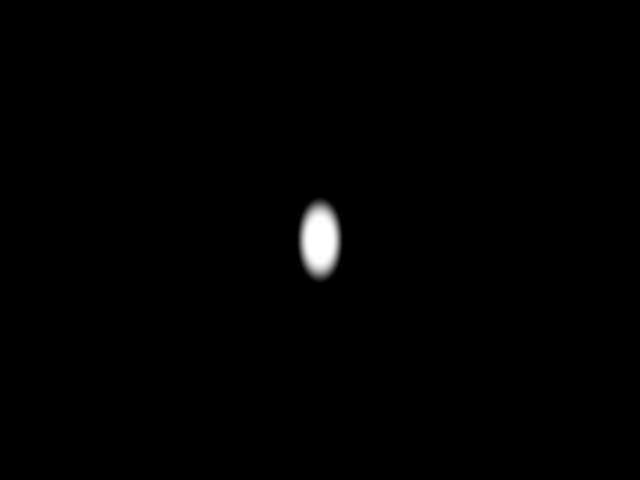

In [70]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sunion(float a, float b, float k) {
    float h = clamp(0.5 + 0.5 * (a - b) / k, 0.0, 1.0);
    return mix(a, b, h) - k * h * (1 - h);
}

float sintersect(float a, float b, float k) {
    float h = clamp(0.5 - 0.5 * (a - b) / k, 0.0, 1.0);
    return mix(a, b, h) + k * h * (1 - h);
}

float sdf_circle(vec2 p, float r) { return length(p) - r; }
float sdf_scene(vec2 p) {
    float sphere_a = sdf_circle(p - vec2(0.16, 0.0), 0.2);
    float sphere_b = sdf_circle(p + vec2(0.16, 0.0), 0.2);
    return sintersect(sphere_a, sphere_b, 0.1);
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = smoothstep(0.01, -0.01, sdf_scene(uv));
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

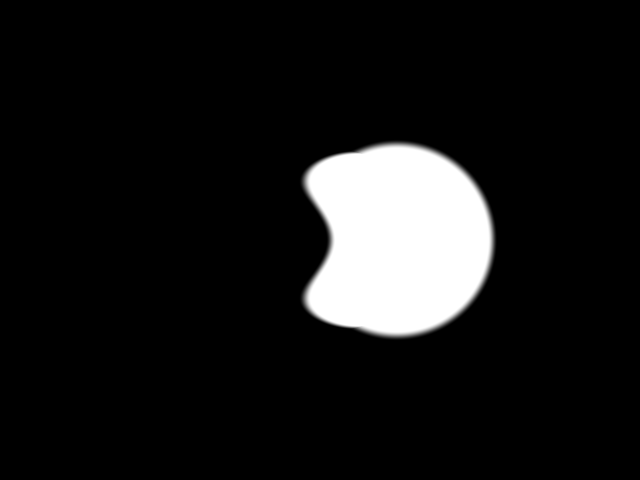

In [71]:
PixelShader("""
#version 330

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sunion(float a, float b, float k) {
    float h = clamp(0.5 + 0.5 * (a - b) / k, 0.0, 1.0);
    return mix(a, b, h) - k * h * (1 - h);
}

float ssubtract(float a, float b, float k) {
    float h = clamp(0.5 - 0.5 * (a + b) / k, 0.0, 1.0);
    return mix(a, -b, h) - k * h * (1 - h);
}

float sintersect(float a, float b, float k) {
    float h = clamp(0.5 - 0.5 * (a - b) / k, 0.0, 1.0);
    return mix(a, b, h) + k * h * (1 - h);
}

float sdf_circle(vec2 p, float r) { return length(p) - r; }
float sdf_scene(vec2 p) {
    float sphere_a = sdf_circle(p - vec2(0.16, 0.0), 0.2);
    float sphere_b = sdf_circle(p + vec2(0.16, 0.0), 0.2);
    return ssubtract(sphere_a, sphere_b, 0.1);
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    float d = smoothstep(0.01, -0.01, sdf_scene(uv));
    f_color = vec4(vec3(d), 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

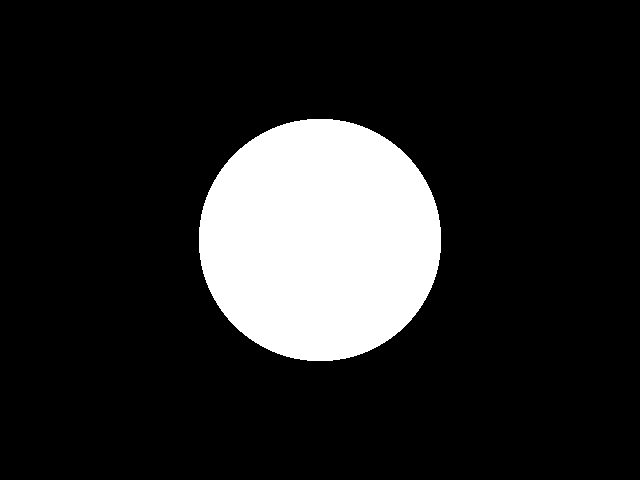

In [107]:
PixelShader("""
#version 330

#define MAX_STEPS 100
#define MAX_DIST 100.0
#define MIN_DIST 0.001

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_sphere(vec3 p, float r) { return length(p) - r; }
float sdf_scene(vec3 p) { return sdf_sphere(p, 0.5); }

vec3 ray_evaluate(vec3 ro, vec3 rd, float t) { return ro + t * rd; }

float ray_marching(vec3 ro, vec3 rd) {
    float t = 0.0;
    for(int step = 0; step < MAX_STEPS; ++step) {
        vec3 p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) break;
        t += h;
        if(t > MAX_DIST) break;
    }
    return (t > MAX_DIST)? -1.0: t;
}

vec3 render(vec3 ro, vec3 rd) {
    float dist = ray_marching(ro, rd);
    return (dist > 0.0)? vec3(dist): vec3(0.0);
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    
    vec3 ro = vec3(0.0, 0.0, 4.0);
    vec3 rd = normalize(vec3(uv, -2));

    vec3 color = render(ro, rd);
    f_color = vec4(color, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

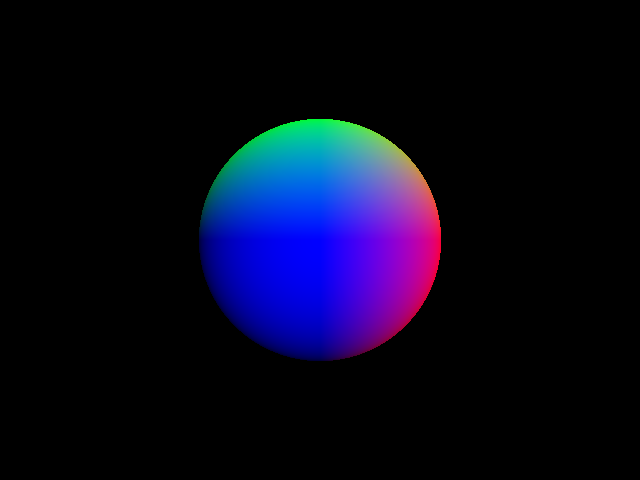

In [108]:
PixelShader("""
#version 330

#define MAX_STEPS 100
#define MAX_DIST 100.0
#define MIN_DIST 0.001

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_sphere(vec3 p, float r) { return length(p) - r; }
float sdf_scene(vec3 p) { return sdf_sphere(p, 0.5); }

vec3 compute_normal(vec3 p) {
    vec2 e = vec2(MIN_DIST, 0.0);
    return normalize(vec3(
        sdf_scene(p + e.xyy) - sdf_scene(p - e.xyy),
        sdf_scene(p + e.yxy) - sdf_scene(p - e.yxy),
        sdf_scene(p + e.yyx) - sdf_scene(p - e.yyx)
    ));
}

vec3 ray_evaluate(vec3 ro, vec3 rd, float t) { return ro + t * rd; }

float ray_marching(vec3 ro, vec3 rd) {
    float t = 0.0;
    for(int step = 0; step < MAX_STEPS; ++step) {
        vec3 p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) break;
        t += h;
        if(t > MAX_DIST) break;
    }
    return (t > MAX_DIST)? -1.0: t;
}

vec3 render(vec3 ro, vec3 rd) {
    vec3 color = vec3(0.0);

    float dist = ray_marching(ro, rd);
    if(dist > 0.0) {
        vec3 p = ray_evaluate(ro, rd, dist);
        vec3 n = compute_normal(p);

        color = n;
    }

    return color;
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    
    vec3 ro = vec3(0.0, 0.0, 4.0);
    vec3 rd = normalize(vec3(uv, -2));

    vec3 color = render(ro, rd);
    f_color = vec4(color, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

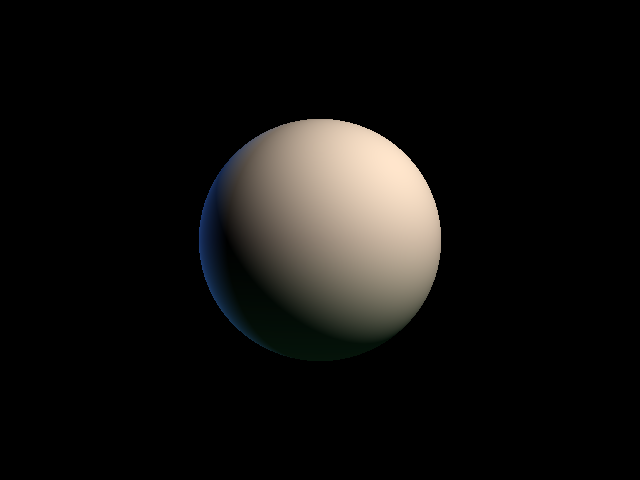

In [130]:
PixelShader("""
#version 330

#define MAX_STEPS 1000
#define MAX_DIST 100.0
#define MIN_DIST 0.001

#define SUN_DIR normalize(vec3(1.0, 1.0, 1.0))
#define SUN_COLOR vec3(1.0, 0.9, 0.8)

#define SKY_DIR normalize(vec3(-1.0, 0.0, -1.0))
#define SKY_COLOR vec3(0.2, 0.4, 0.8)

#define BOUNCE_DIR normalize(vec3(0.0, -1.0, 0.0))
#define BOUNCE_COLOR vec3(0.2, 0.8, 0.4)
#define BOUNCE_INTENSITY 0.1

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_sphere(vec3 p, float r) { return length(p) - r; }
float sdf_scene(vec3 p) { return sdf_sphere(p, 0.5); }

vec3 compute_normal(vec3 p) {
    vec2 e = vec2(MIN_DIST, 0.0);
    return normalize(vec3(
        sdf_scene(p + e.xyy) - sdf_scene(p - e.xyy),
        sdf_scene(p + e.yxy) - sdf_scene(p - e.yxy),
        sdf_scene(p + e.yyx) - sdf_scene(p - e.yyx)
    ));
}

vec3 ray_evaluate(vec3 ro, vec3 rd, float t) { return ro + t * rd; }

float ray_marching(vec3 ro, vec3 rd) {
    float t = 0.0;
    for(int step = 0; step < MAX_STEPS; ++step) {
        vec3 p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) break;
        t += h;
        if(t > MAX_DIST) break;
    }
    return (t > MAX_DIST)? -1.0: t;
}

vec3 render(vec3 ro, vec3 rd) {
    vec3 color = vec3(0.0);

    float dist = ray_marching(ro, rd);
    if(dist > 0.0) {
        vec3 p = ray_evaluate(ro, rd, dist);
        vec3 n = compute_normal(p);

        color  = clamp(dot(n, SUN_DIR), 0.0, 1.0) * SUN_COLOR;
        color += clamp(dot(n, SKY_DIR), 0.0, 1.0) * SKY_COLOR;
        color += clamp(dot(n, BOUNCE_DIR), 0.0, 1.0) * BOUNCE_COLOR * BOUNCE_INTENSITY;
    }

    return color;
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    
    vec3 ro = vec3(0.0, 0.0, 4.0);
    vec3 rd = normalize(vec3(uv, -2));

    vec3 color = render(ro, rd);
    f_color = vec4(color, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

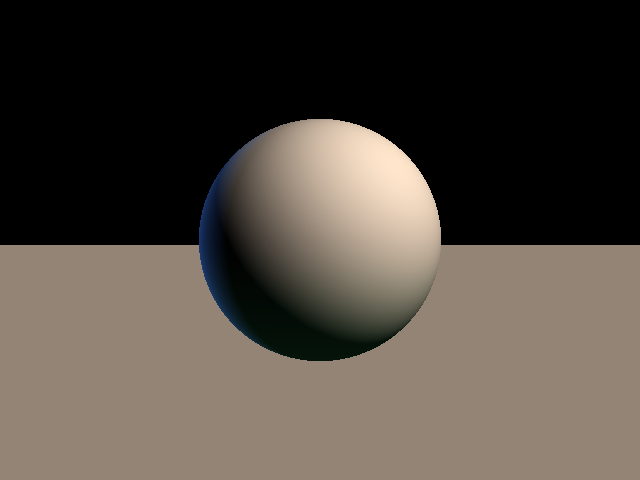

In [157]:
PixelShader("""
#version 330

#define MAX_STEPS 1000
#define MAX_DIST 100.0
#define MIN_DIST 0.001

#define SUN_DIR normalize(vec3(1.0, 1.0, 1.0))
#define SUN_COLOR vec3(1.0, 0.9, 0.8)

#define SKY_DIR normalize(vec3(-1.0, 0.0, -1.0))
#define SKY_COLOR vec3(0.2, 0.4, 0.8)

#define BOUNCE_DIR normalize(vec3(0.0, -1.0, 0.0))
#define BOUNCE_COLOR vec3(0.2, 0.8, 0.4)
#define BOUNCE_INTENSITY 0.1

#define UP vec3(0.0, 1.0, 0.0)

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_plane(vec3 p, vec3 n, float h) { return dot(p, n) + h; }
float sdf_sphere(vec3 p, float r) { return length(p) - r; }
float sdf_scene(vec3 p) {
    float sphere = sdf_sphere(p, 0.5);
    float plane = sdf_plane(p, UP, 0.5);
    return min(sphere, plane);
}

vec3 compute_normal(vec3 p) {
    vec2 e = vec2(MIN_DIST, 0.0);
    return normalize(vec3(
        sdf_scene(p + e.xyy) - sdf_scene(p - e.xyy),
        sdf_scene(p + e.yxy) - sdf_scene(p - e.yxy),
        sdf_scene(p + e.yyx) - sdf_scene(p - e.yyx)
    ));
}

vec3 ray_evaluate(vec3 ro, vec3 rd, float t) { return ro + t * rd; }

float ray_marching(vec3 ro, vec3 rd) {
    float t = 0.0;
    for(int step = 0; step < MAX_STEPS; ++step) {
        vec3 p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) break;
        t += h;
        if(t > MAX_DIST) break;
    }
    return (t > MAX_DIST)? -1.0: t;
}

vec3 render(vec3 ro, vec3 rd) {
    vec3 color = vec3(0.0);

    float dist = ray_marching(ro, rd);
    if(dist > 0.0) {
        vec3 p = ray_evaluate(ro, rd, dist);
        vec3 n = compute_normal(p);

        color  = clamp(dot(n, SUN_DIR), 0.0, 1.0) * SUN_COLOR;
        color += clamp(dot(n, SKY_DIR), 0.0, 1.0) * SKY_COLOR;
        color += clamp(dot(n, BOUNCE_DIR), 0.0, 1.0) * BOUNCE_COLOR * BOUNCE_INTENSITY;
    }

    return color;
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    
    vec3 ro = vec3(0.0, 0.0, 4.0);
    vec3 rd = normalize(vec3(uv, -2));

    vec3 color = render(ro, rd);
    f_color = vec4(color, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

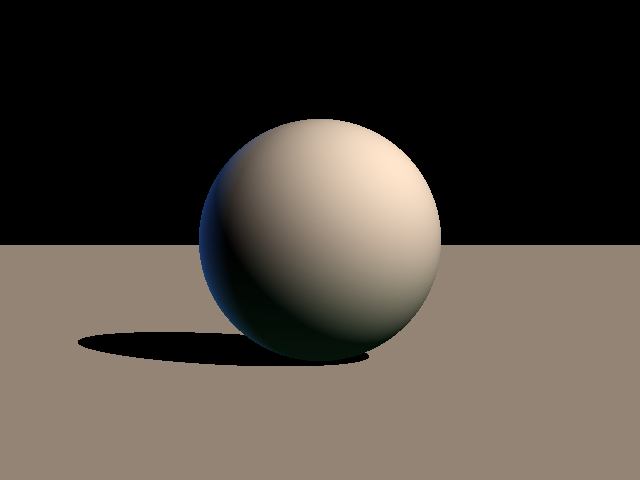

In [188]:
PixelShader("""
#version 330

#define MAX_STEPS 1000
#define MAX_DIST 100.0
#define MIN_DIST 0.001

#define SUN_DIR normalize(vec3(1.0, 1.0, 1.0))
#define SUN_COLOR vec3(1.0, 0.9, 0.8)

#define SKY_DIR normalize(vec3(-1.0, 0.0, -1.0))
#define SKY_COLOR vec3(0.2, 0.4, 0.8)

#define BOUNCE_DIR normalize(vec3(0.0, -1.0, 0.0))
#define BOUNCE_COLOR vec3(0.2, 0.8, 0.4)
#define BOUNCE_INTENSITY 0.1

#define UP vec3(0.0, 1.0, 0.0)

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_plane(vec3 p, vec3 n, float h) { return dot(p, n) + h; }
float sdf_sphere(vec3 p, float r) { return length(p) - r; }
float sdf_scene(vec3 p) {
    float sphere = sdf_sphere(p, 0.5);
    float plane = sdf_plane(p, UP, 0.5);
    return min(sphere, plane);
}

vec3 compute_normal(vec3 p) {
    vec2 e = vec2(MIN_DIST, 0.0);
    return normalize(vec3(
        sdf_scene(p + e.xyy) - sdf_scene(p - e.xyy),
        sdf_scene(p + e.yxy) - sdf_scene(p - e.yxy),
        sdf_scene(p + e.yyx) - sdf_scene(p - e.yyx)
    ));
}

vec3 ray_evaluate(vec3 ro, vec3 rd, float t) { return ro + t * rd; }

float ray_marching(vec3 ro, vec3 rd) {
    float t = 0.0;
    for(int step = 0; step < MAX_STEPS; ++step) {
        vec3 p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) break;
        t += h;
        if(t > MAX_DIST) break;
    }
    return (t > MAX_DIST)? -1.0: t;
}

float shadow(vec3 p, vec3 n, vec3 ld) {
    float dist = ray_marching(p + n * MIN_DIST * 2.0, ld);
    return (dist < 0.0)? 1.0: 0.0;
}

vec3 render(vec3 ro, vec3 rd) {
    vec3 color = vec3(0.0);

    float dist = ray_marching(ro, rd);
    if(dist > 0.0) {
        vec3 p = ray_evaluate(ro, rd, dist);
        vec3 n = compute_normal(p);

        float sun_shadow = shadow(p, n, SUN_DIR);

        color  = clamp(dot(n, SUN_DIR), 0.0, 1.0) * SUN_COLOR * sun_shadow;
        color += clamp(dot(n, SKY_DIR), 0.0, 1.0) * SKY_COLOR;
        color += clamp(dot(n, BOUNCE_DIR), 0.0, 1.0) * BOUNCE_COLOR * BOUNCE_INTENSITY;
    }

    return color;
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    
    vec3 ro = vec3(0.0, 0.0, 4.0);
    vec3 rd = normalize(vec3(uv, -2));

    vec3 color = render(ro, rd);
    f_color = vec4(color, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

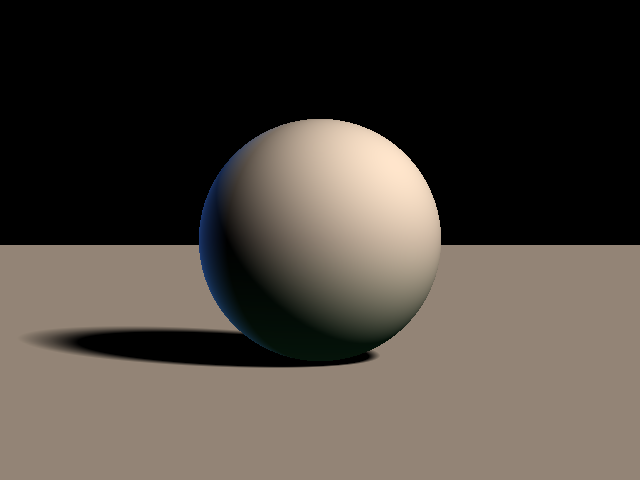

In [187]:
PixelShader("""
#version 330

#define MAX_STEPS 1000
#define MAX_DIST 100.0
#define MIN_DIST 0.001

#define MAX_SHADOW_STEPS 100
#define SHADOW_K_FACTOR 8

#define SUN_DIR normalize(vec3(1.0, 1.0, 1.0))
#define SUN_COLOR vec3(1.0, 0.9, 0.8)

#define SKY_DIR normalize(vec3(-1.0, 0.0, -1.0))
#define SKY_COLOR vec3(0.2, 0.4, 0.8)

#define BOUNCE_DIR normalize(vec3(0.0, -1.0, 0.0))
#define BOUNCE_COLOR vec3(0.2, 0.8, 0.4)
#define BOUNCE_INTENSITY 0.1

#define UP vec3(0.0, 1.0, 0.0)

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_plane(vec3 p, vec3 n, float h) { return dot(p, n) + h; }
float sdf_sphere(vec3 p, float r) { return length(p) - r; }
float sdf_scene(vec3 p) {
    float sphere = sdf_sphere(p, 0.5);
    float plane = sdf_plane(p, UP, 0.5);
    return min(sphere, plane);
}

vec3 compute_normal(vec3 p) {
    vec2 e = vec2(MIN_DIST, 0.0);
    return normalize(vec3(
        sdf_scene(p + e.xyy) - sdf_scene(p - e.xyy),
        sdf_scene(p + e.yxy) - sdf_scene(p - e.yxy),
        sdf_scene(p + e.yyx) - sdf_scene(p - e.yyx)
    ));
}

vec3 ray_evaluate(vec3 ro, vec3 rd, float t) { return ro + t * rd; }

float ray_marching(vec3 ro, vec3 rd) {
    float t = 0.0;
    for(int step = 0; step < MAX_STEPS; ++step) {
        vec3 p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) break;
        t += h;
        if(t > MAX_DIST) break;
    }
    return (t > MAX_DIST)? -1.0: t;
}

float shadow(vec3 p, vec3 n, vec3 ld) {
    vec3 ro = p + n * MIN_DIST * 2.0;
    vec3 rd = ld;

    float r = 1.0;
    float t = 0.0;
    for(int step = 0; step < MAX_SHADOW_STEPS; ++step) {
        p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) return 0.0;
        t += h;
        r = min(r, SHADOW_K_FACTOR * h / t);
    }
    return r;
}

vec3 render(vec3 ro, vec3 rd) {
    vec3 color = vec3(0.0);

    float dist = ray_marching(ro, rd);
    if(dist > 0.0) {
        vec3 p = ray_evaluate(ro, rd, dist);
        vec3 n = compute_normal(p);

        float sun_shadow = shadow(p, n, SUN_DIR);

        color  = clamp(dot(n, SUN_DIR), 0.0, 1.0) * SUN_COLOR * sun_shadow;
        color += clamp(dot(n, SKY_DIR), 0.0, 1.0) * SKY_COLOR;
        color += clamp(dot(n, BOUNCE_DIR), 0.0, 1.0) * BOUNCE_COLOR * BOUNCE_INTENSITY;
    }

    return color;
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    
    vec3 ro = vec3(0.0, 0.0, 4.0);
    vec3 rd = normalize(vec3(uv, -2));

    vec3 color = render(ro, rd);
    f_color = vec4(color, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

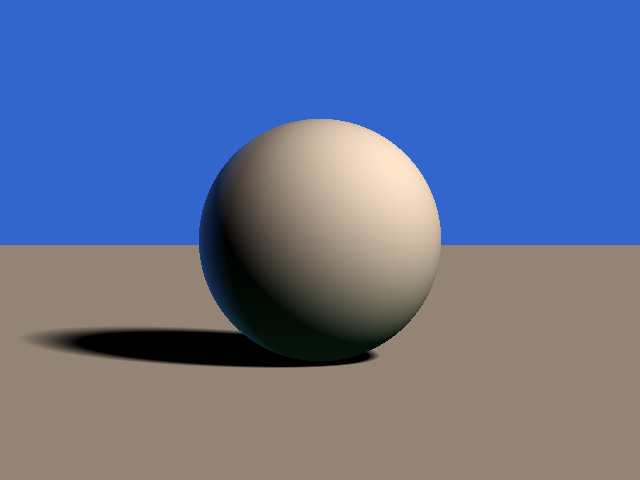

In [189]:
PixelShader("""
#version 330

#define MAX_STEPS 1000
#define MAX_DIST 100.0
#define MIN_DIST 0.001

#define MAX_SHADOW_STEPS 100
#define SHADOW_K_FACTOR 8

#define SUN_DIR normalize(vec3(1.0, 1.0, 1.0))
#define SUN_COLOR vec3(1.0, 0.9, 0.8)

#define SKY_DIR normalize(vec3(-1.0, 0.0, -1.0))
#define SKY_COLOR vec3(0.2, 0.4, 0.8)

#define BOUNCE_DIR normalize(vec3(0.0, -1.0, 0.0))
#define BOUNCE_COLOR vec3(0.2, 0.8, 0.4)
#define BOUNCE_INTENSITY 0.1

#define UP vec3(0.0, 1.0, 0.0)

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_plane(vec3 p, vec3 n, float h) { return dot(p, n) + h; }
float sdf_sphere(vec3 p, float r) { return length(p) - r; }
float sdf_scene(vec3 p) {
    float sphere = sdf_sphere(p, 0.5);
    float plane = sdf_plane(p, UP, 0.5);
    return min(sphere, plane);
}

vec3 compute_normal(vec3 p) {
    vec2 e = vec2(MIN_DIST, 0.0);
    return normalize(vec3(
        sdf_scene(p + e.xyy) - sdf_scene(p - e.xyy),
        sdf_scene(p + e.yxy) - sdf_scene(p - e.yxy),
        sdf_scene(p + e.yyx) - sdf_scene(p - e.yyx)
    ));
}

vec3 ray_evaluate(vec3 ro, vec3 rd, float t) { return ro + t * rd; }

float ray_marching(vec3 ro, vec3 rd) {
    float t = 0.0;
    for(int step = 0; step < MAX_STEPS; ++step) {
        vec3 p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) break;
        t += h;
        if(t > MAX_DIST) break;
    }
    return (t > MAX_DIST)? -1.0: t;
}

float shadow(vec3 p, vec3 n, vec3 ld) {
    vec3 ro = p + n * MIN_DIST * 2.0;
    vec3 rd = ld;

    float r = 1.0;
    float t = 0.0;
    for(int step = 0; step < MAX_SHADOW_STEPS; ++step) {
        p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) return 0.0;
        t += h;
        r = min(r, SHADOW_K_FACTOR * h / t);
    }
    return r;
}

vec3 render(vec3 ro, vec3 rd) {
    vec3 color = SKY_COLOR;

    float dist = ray_marching(ro, rd);
    if(dist > 0.0) {
        vec3 p = ray_evaluate(ro, rd, dist);
        vec3 n = compute_normal(p);

        float sun_shadow = shadow(p, n, SUN_DIR);

        color  = clamp(dot(n, SUN_DIR), 0.0, 1.0) * SUN_COLOR * sun_shadow;
        color += clamp(dot(n, SKY_DIR), 0.0, 1.0) * SKY_COLOR;
        color += clamp(dot(n, BOUNCE_DIR), 0.0, 1.0) * BOUNCE_COLOR * BOUNCE_INTENSITY;
    }

    return color;
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    
    vec3 ro = vec3(0.0, 0.0, 4.0);
    vec3 rd = normalize(vec3(uv, -2));

    vec3 color = render(ro, rd);
    f_color = vec4(color, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()

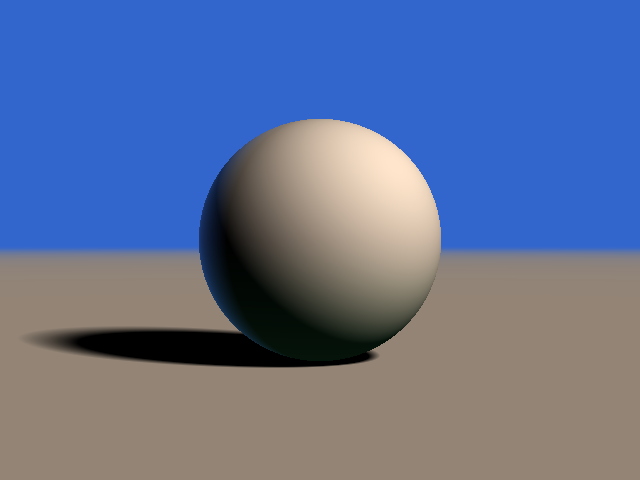

In [206]:
PixelShader("""
#version 330

#define MAX_STEPS 1000
#define MAX_DIST 100.0
#define MIN_DIST 0.001

#define MAX_SHADOW_STEPS 100
#define SHADOW_K_FACTOR 8

#define SUN_DIR normalize(vec3(1.0, 1.0, 1.0))
#define SUN_COLOR vec3(1.0, 0.9, 0.8)

#define SKY_DIR normalize(vec3(-1.0, 0.0, -1.0))
#define SKY_COLOR vec3(0.2, 0.4, 0.8)

#define BOUNCE_DIR normalize(vec3(0.0, -1.0, 0.0))
#define BOUNCE_COLOR vec3(0.2, 0.8, 0.4)
#define BOUNCE_INTENSITY 0.1

#define UP vec3(0.0, 1.0, 0.0)

uniform vec2 u_res;

in vec2 v_uv;

out vec4 f_color;

float sdf_plane(vec3 p, vec3 n, float h) { return dot(p, n) + h; }
float sdf_sphere(vec3 p, float r) { return length(p) - r; }
float sdf_scene(vec3 p) {
    float sphere = sdf_sphere(p, 0.5);
    float plane = sdf_plane(p, UP, 0.5);
    return min(sphere, plane);
}

vec3 compute_normal(vec3 p) {
    vec2 e = vec2(MIN_DIST, 0.0);
    return normalize(vec3(
        sdf_scene(p + e.xyy) - sdf_scene(p - e.xyy),
        sdf_scene(p + e.yxy) - sdf_scene(p - e.yxy),
        sdf_scene(p + e.yyx) - sdf_scene(p - e.yyx)
    ));
}

vec3 ray_evaluate(vec3 ro, vec3 rd, float t) { return ro + t * rd; }

float ray_marching(vec3 ro, vec3 rd) {
    float t = 0.0;
    for(int step = 0; step < MAX_STEPS; ++step) {
        vec3 p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) break;
        t += h;
        if(t > MAX_DIST) break;
    }
    return (t > MAX_DIST)? -1.0: t;
}

float shadow(vec3 p, vec3 n, vec3 ld) {
    vec3 ro = p + n * MIN_DIST * 2.0;
    vec3 rd = ld;

    float r = 1.0;
    float t = 0.0;
    for(int step = 0; step < MAX_SHADOW_STEPS; ++step) {
        p = ray_evaluate(ro, rd, t);
        float h = sdf_scene(p);
        if(h < MIN_DIST) return 0.0;
        t += h;
        r = min(r, SHADOW_K_FACTOR * h / t);
    }
    return r;
}

vec3 render(vec3 ro, vec3 rd) {
    vec3 color = SKY_COLOR;

    float dist = ray_marching(ro, rd);
    if(dist > 0.0) {
        vec3 p = ray_evaluate(ro, rd, dist);
        vec3 n = compute_normal(p);

        float sun_shadow = shadow(p, n, SUN_DIR);

        color  = clamp(dot(n, SUN_DIR), 0.0, 1.0) * SUN_COLOR * sun_shadow;
        color += clamp(dot(n, SKY_DIR), 0.0, 1.0) * SKY_COLOR;
        color += clamp(dot(n, BOUNCE_DIR), 0.0, 1.0) * BOUNCE_COLOR * BOUNCE_INTENSITY;
        
        color = mix(color, SKY_COLOR, 1.0 - exp(-0.01 * MIN_DIST * dist * dist * dist));
    }

    return color;
}

void main() {
    float ar = u_res.x / u_res.y;
    vec2 uv = (v_uv - 0.5) * vec2(ar, 1.0);
    
    vec3 ro = vec3(0.0, 0.0, 4.0);
    vec3 rd = normalize(vec3(uv, -2));

    vec3 color = render(ro, rd);
    f_color = vec4(color, 1.0);
}
""", uniforms = {
    "u_res": np.array(FRAME_SIZE, dtype=np.float32),
}).render().show()